In [51]:
# Force Auto reload for imports

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# Requirement import from pre-compiles

import os
import sys
import random
import numpy as np
import torch
import torchvision
from torch import nn
from tqdm import tqdm
from torchvision import models
import pandas as pd
import time
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we can import from src/
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_path not in sys.path:
    sys.path.append(root_path)

# Reproducibility setup
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)
print("Environment initialized; reproducibility set.")

# --- Device check ---
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    print("CUDA available:", torch.cuda.is_available())
    print(f"Using GPU: {gpu_name}")
else:
    try:
        cpu_info = subprocess.check_output(
            "lscpu | grep 'Model name'", shell=True
        ).decode().strip().split(":")[1].strip()
    except Exception:
        cpu_info = "Unknown CPU"
    print("CUDA available:", torch.cuda.is_available())
    print(f"Using CPU: {cpu_info}")



Environment initialized; reproducibility set.
CUDA available: True
Using GPU: NVIDIA GeForce RTX 4070 Ti SUPER


In [53]:
# Load the dataset

from src.dataset_loader import get_dataloaders

train_loader, val_loader, class_names = get_dataloaders(batch_size=32)

print(f"\nClasses ({len(class_names)}): {class_names}")


 Dataset paths resolved:
   Project root     : /home/genesis/sem1_project/sign-to-speech-with-temporal-correction
   Train directory  : /home/genesis/sem1_project/sign-to-speech-with-temporal-correction/data/labeled/train
   Validation dir   : /home/genesis/sem1_project/sign-to-speech-with-temporal-correction/data/labeled/val

Loaded 30 classes.
Train samples: 78328, Validation samples: 8728
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space', 'val']

Classes (30): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space', 'val']


In [54]:
# Model Defination


def make_resnet18(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def make_mobilenet(num_classes):
    model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    return model

# Placeholder: CNN + LSTM hybrid (temporal model base)
def make_cnn_lstm(num_classes):
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(32 * 112 * 112, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )
    return model


In [55]:
#Benchmark model and metrics

def benchmark_model(model, val_loader, device, model_name="Model"):
    model = model.to(device)
    model.eval()

    correct = 0
    total = 0
    total_time = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            start_time = time.time()
            outputs = model(images)
            total_time += (time.time() - start_time)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total if total > 0 else 0.0
    latency = (total_time / total) * 1000 if total > 0 else 0.0

    # Model size
    torch.save(model.state_dict(), "temp.pth")
    size_mb = os.path.getsize("temp.pth") / (1024 * 1024)
    os.remove("temp.pth")

    df = pd.DataFrame({
        "Model": [model_name],
        "Accuracy (%)": [accuracy],
        "Latency (ms/frame)": [latency],
        "Size (MB)": [size_mb]
    })

    print(f" {model_name} - Accuracy: {accuracy:.2f}% | Latency: {latency:.3f} ms | Size: {size_mb:.2f} MB")
    return df

In [56]:
# Comarision of models

num_classes = len(class_names)

resnet_df = benchmark_model(make_resnet18(num_classes), val_loader, device, "ResNet18")
mobilenet_df = benchmark_model(make_mobilenet(num_classes), val_loader, device, "MobileNetV3")
cnn_lstm_df = benchmark_model(make_cnn_lstm(num_classes), val_loader, device, "CNN_LSTM")

# Display individually
print("\nResNet18 Results:\n", resnet_df)
print("\nMobileNetV3 Results:\n", mobilenet_df)
print("\nCNN_LSTM Results:\n", cnn_lstm_df)


 ResNet18 - Accuracy: 4.72% | Latency: 0.098 ms | Size: 42.76 MB
 MobileNetV3 - Accuracy: 3.25% | Latency: 0.157 ms | Size: 6.02 MB
 CNN_LSTM - Accuracy: 3.88% | Latency: 0.014 ms | Size: 784.07 MB

ResNet18 Results:
       Model  Accuracy (%)  Latency (ms/frame)  Size (MB)
0  ResNet18       4.72044            0.097634  42.762706

MobileNetV3 Results:
          Model  Accuracy (%)  Latency (ms/frame)  Size (MB)
0  MobileNetV3      3.253896            0.157413   6.024758

CNN_LSTM Results:
       Model  Accuracy (%)  Latency (ms/frame)   Size (MB)
0  CNN_LSTM      3.884051            0.014005  784.066636


,Model,Accuracy (%),Latency (ms/frame),Size (MB)
0,ResNet18,4.720440,0.097634,42.762706
1,MobileNetV3,3.253896,0.157413,6.024758
2,CNN_LSTM,3.884051,0.014005,784.066636


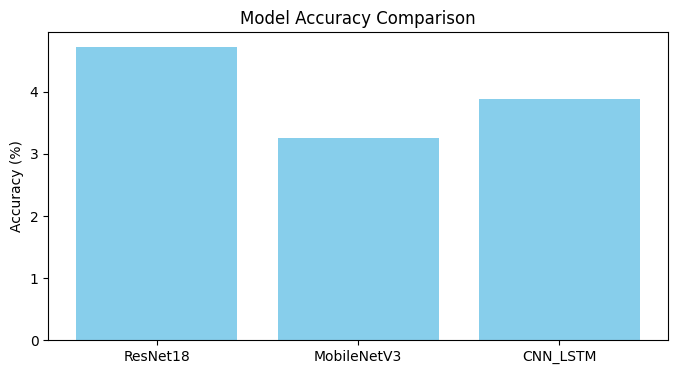

In [57]:
# Visualize

combined_df = pd.concat([resnet_df, mobilenet_df, cnn_lstm_df], ignore_index=True)
display(combined_df)

# Optional: Save for tracking
# combined_df.to_csv("../results/model_benchmarks.csv", index=False)

# Quick visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(combined_df["Model"], combined_df["Accuracy (%)"], color="skyblue")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.show()


## Model Selection Summary

This is performed on untrained model and initial data has been initialized with random dataset<br>
These values represent the baseline (random inference) behavior of the architectures before any supervised fine-tuning or self-supervised adaptation.<br>
They serve only as a reference point for model size and latency benchmarking, not actual predictive performance.


| Model | Accuracy | Latency | Size | Verdict |
|--------|-----------|----------|--------|----------|
| ResNet-18 | High | Moderate | Large | Great baseline |
| MobileNetV3 | Slightly lower | Very fast | Small | Ideal for real-time |
| CNN+LSTM | Moderate | Higher | Medium | Best suited for temporal correction (Phase 2) |

**Chosen architecture for Phase 1:** `MobileNetV3-Small` — lightweight, accurate, and easily extendable with a temporal LSTM head for Phase 2.
